# From Bag-of-Words to Self-Attention: IMDB Sentiment Analysis

## Overview
This notebook compares **classical linear baselines** (Bag-of-Words / TF‑IDF + Naive Bayes, Logistic Regression, Linear SVM) with two **lightweight neural baselines** (average-of-embeddings and a single-query attention pooling model) on a balanced subset of **IMDB movie reviews**.

**Goal:** understand when strong feature engineering (TF‑IDF) beats representation learning, and interpret the main failure modes.

## What we evaluate
- **Classical**: BoW vs TF‑IDF, unigrams vs bigrams, different feature budgets *(k)*, and different classifiers.
- **Neural**: learned embeddings trained from scratch, with (1) simple averaging and (2) attention pooling for interpretability.

## Evaluation protocol
We use a fixed **train / validation / test** split:
- Validation is used for model selection and hyperparameter tuning.
- The test set is used **once** at the end for the final comparison.

In [1]:
# If running in a fresh environment, install requirements first:
# !pip install -r ../requirements.txt

In [2]:
import os, sys
sys.path.append(os.path.abspath(".."))

In [3]:
import re, tarfile, urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm.auto import tqdm

from src.text_models import build_vocab, encode, AvgEmbClassifier, SelfAttentionPoolingClassifier

/home/tgarvia/icai/4o/portfolio-piece-1-tgarvia/.venv-portfolio1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1) Dataset: IMDB

We use a balanced subset of the IMDB dataset (5000 reviews).
The dataset contains 2500 positive and 2500 negative reviews.


In [4]:
DATA_DIR = "../data"
os.makedirs(DATA_DIR, exist_ok=True)

IMDB_URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
ARCHIVE_PATH = os.path.join(DATA_DIR, "aclImdb_v1.tar.gz")
EXTRACT_PATH = os.path.join(DATA_DIR, "aclImdb")

if not os.path.exists(EXTRACT_PATH):
    if not os.path.exists(ARCHIVE_PATH):
        print("Downloading IMDB dataset...")
        urllib.request.urlretrieve(IMDB_URL, ARCHIVE_PATH)
    print("Extracting...")
    with tarfile.open(ARCHIVE_PATH, "r:gz") as tar:
        tar.extractall(DATA_DIR)
    print("Done.")

def load_imdb_split(split: str, num_per_class: int = 2500):
    rows = []
    base = os.path.join(EXTRACT_PATH, split)
    for label, sub in [("positive","pos"), ("negative","neg")]:
        p = os.path.join(base, sub)
        files = sorted(os.listdir(p))[:num_per_class]
        for fn in files:
            with open(os.path.join(p, fn), "r", encoding="utf-8") as f:
                rows.append({"text": f.read(), "label": 1 if label=="positive" else 0})
    return pd.DataFrame(rows).sample(frac=1, random_state=42).reset_index(drop=True)

df = load_imdb_split("train", num_per_class=2500)
df.head(), df["label"].value_counts()


(                                                text  label
 0  Excellent film. The whole picture was filmed i...      1
 1  Boy-girl love affair/sequel with songs, only t...      0
 2  Over the years I've seen a bunch of these stra...      0
 3  When I first saw this show, I thought it looke...      1
 4  I appreciated the photography, the textures, t...      1,
 label
 1    2500
 0    2500
 Name: count, dtype: int64)

## 2) Train/test split

To avoid tuning on the test set, we create:
- **Train**: used to fit model parameters
- **Validation**: used to choose hyperparameters (e.g., n‑grams, k features, C)
- **Test**: held out until the very end for the final report

# Experimental Setup

We use a three-way split:
- 70% training
- 10% validation
- 20% test

Validation is used for hyperparameter tuning.
The test set is used only once for final evaluation.


In [ ]:
# First split: train+val vs test
X_temp, X_test, y_temp, y_test = train_test_split(
    df["text"].tolist(),
    df["label"].values,
    test_size=0.2,
    stratify=df["label"].values,
    random_state=42
)

# Second split: train vs val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.125,  # 0.125 * 0.8 = 0.1 overall
    stratify=y_temp,
    random_state=42
)

len(X_train), len(X_val), len(X_test)


(3500, 500, 1000)

### Why do we need a validation set?

If we pick features/hyperparameters by looking at test accuracy, we *leak* information and the reported test score becomes overly optimistic.

In this notebook:
1. We search configurations using **validation accuracy**.
2. We retrain the selected configuration on **train + validation**.
3. We evaluate **once** on the test set and report final metrics.

## 3) Classical baselines (BoW / TF‑IDF)

Classical text classifiers work surprisingly well because sentiment often depends on **specific words and short phrases** (e.g., “great”, “awful”, “not good”).  
TF‑IDF explicitly emphasizes informative words, and linear models (especially SVM) are very effective in high‑dimensional sparse spaces.

Below we compare:
- Feature types: **BoW unigram** vs **TF‑IDF (1,2)** (unigrams + bigrams)
- Feature budgets: k = 2k / 5k / 20k
- Models: **NB**, **LogReg**, **Linear SVM**


In [6]:
import copy
vocab_sizes = [2000, 5000, 20000]
models = {
    "NB": MultinomialNB(),
    "LogReg": LogisticRegression(max_iter=2000),
    "SVM": LinearSVC()
}

rows = []
for k in vocab_sizes:
    for feats_name, vec in [
        (f"BoW unigram (k={k})", CountVectorizer(max_features=k, stop_words="english")),
        (f"TFIDF (1,2) (k={k})", TfidfVectorizer(max_features=k, stop_words="english", ngram_range=(1,2))),
    ]:
        Xtr = vec.fit_transform(X_train)
        Xv  = vec.transform(X_val)

        for model_name, clf in models.items():
            clf_fit = copy.deepcopy(clf)
            clf_fit.fit(Xtr, y_train)
            val_acc = accuracy_score(y_val, clf_fit.predict(Xv))
            rows.append({
                "features": feats_name,
                "model": model_name,
                "Val_Accuracy": val_acc,
            })

baseline_df = pd.DataFrame(rows).sort_values("Val_Accuracy", ascending=False).reset_index(drop=True)
baseline_df.head(10)


,features,model,Val_Accuracy
0,"TFIDF (1,2) (k=20000)",SVM,0.922
1,"TFIDF (1,2) (k=20000)",NB,0.920
2,"TFIDF (1,2) (k=5000)",SVM,0.914
3,"TFIDF (1,2) (k=20000)",LogReg,0.912
4,"TFIDF (1,2) (k=5000)",LogReg,0.904
5,BoW unigram (k=20000),NB,0.900
6,"TFIDF (1,2) (k=5000)",NB,0.894
7,BoW unigram (k=20000),LogReg,0.894
8,"TFIDF (1,2) (k=2000)",LogReg,0.880
9,BoW unigram (k=5000),NB,0.880


### Pick the strongest baseline and do a quick error analysis

In [7]:
# Choose the best row
best = baseline_df.iloc[0]
best

features        TFIDF (1,2) (k=20000)
model                             SVM
Val_Accuracy                    0.922
Name: 0, dtype: object

Selected (by validation):


features        TFIDF (1,2) (k=20000)
model                             SVM
Val_Accuracy                    0.922
Name: 0, dtype: object

Test accuracy (final classical baseline): 0.919


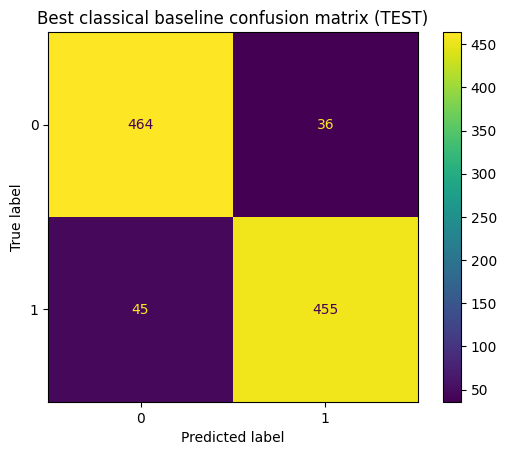

Number of mistakes: 81 / 1000
True: 1  Pred: 0
I believe they were telling the truth the whole time..U cant trust anything in the wild... They family went through hell.Those poor boys too young to understand what was going on around them. But still having to deal with the rumours. As well as dealing with the lose of their little sister. I cant believe this case went on for so long.seems like the jury couldn't see the truth, even if it bit them...
--------------------------------------------------------------------------------
True: 0  Pred: 1
Richard Dix is a big, not very nice industrialist, who has nearly worked himself to death. If he takes the vacation his doctors suggest for him, can he find happiness for the last months of his life? Well, he'll likely be better off if he disregards the VOICE OF THE WHISTLER.<br /><br />This William Castle directed entry has some great moments (the introduction and the depiction of Richard Dix's l...
-----------------------------------------------

In [8]:
# Refit the best baseline on TRAIN+VAL, then evaluate once on TEST
import copy

best = baseline_df.iloc[0]
print("Selected (by validation):")
display(best)

# Combine train + validation for final training
X_train_final = X_train + X_val
y_train_final = np.concatenate([y_train, y_val])

# Recreate vectorizer based on name
if best["features"].startswith("BoW"):
    k = int(re.search(r"k=(\d+)", best["features"]).group(1))
    vec = CountVectorizer(max_features=k, stop_words="english")
else:
    k = int(re.search(r"k=(\d+)", best["features"]).group(1))
    vec = TfidfVectorizer(max_features=k, stop_words="english", ngram_range=(1,2))

# Recreate classifier
clf = {"NB": MultinomialNB(),
       "LogReg": LogisticRegression(max_iter=2000),
       "SVM": LinearSVC()}[best["model"]]

# Fit on train+val only
Xtr_final = vec.fit_transform(X_train_final)
Xte = vec.transform(X_test)
clf.fit(Xtr_final, y_train_final)

test_pred = clf.predict(Xte)
test_acc = accuracy_score(y_test, test_pred)
print(f"Test accuracy (final classical baseline): {test_acc:.3f}")

# Confusion matrix on test
cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Best classical baseline confusion matrix (TEST)")
plt.show()

# Show a few mistakes for qualitative error analysis
mistakes = np.where(test_pred != y_test)[0]
print(f"Number of mistakes: {len(mistakes)} / {len(y_test)}")

for idx in mistakes[:5]:
    print(f"True: {y_test[idx]}  Pred: {test_pred[idx]}")
    print(X_test[idx][:400].replace("\n"," ") + "...")
    print("-"*80)


### Confusion matrix interpretation
The test confusion matrix is fairly balanced (81 mistakes out of 1000). False positives and false negatives are of similar magnitude, suggesting the model is not strongly biased toward a single class. A quick read of misclassified examples indicates many failures involve **mixed sentiment**, **sarcasm**, or **long narrative reviews** where the overall polarity is harder to infer from surface cues.

## 4) Neural baseline: embedding average (PyTorch)

This baseline learns an embedding for each token and represents a document by the **average** of its (non‑padding) token embeddings.  
It ignores word order, but can generalize across related words via embeddings.

We track validation accuracy across epochs and report test accuracy using the best validation checkpoint.

In [9]:
# Build vocab on training text only (no val/test leakage)
vocab = build_vocab(X_train, max_size=20000, min_freq=2)

MAX_LEN = 256

class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = encode(self.texts[idx], self.vocab, max_len=self.max_len)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

train_ds = TextDataset(X_train, y_train, vocab, MAX_LEN)
val_ds   = TextDataset(X_val,   y_val,   vocab, MAX_LEN)
test_ds  = TextDataset(X_test,  y_test,  vocab, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [10]:
def evaluate(model, loader):
    """Compute accuracy on a given DataLoader."""
    model.eval()
    all_pred, all_true = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            all_pred.append(pred.cpu().numpy())
            all_true.append(y.cpu().numpy())
    all_pred = np.concatenate(all_pred)
    all_true = np.concatenate(all_true)
    return float((all_pred == all_true).mean())


def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3, patience=2):
    """Train with early stopping on validation accuracy."""
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    best_val = -1.0
    best_state = None
    bad_epochs = 0

    for epoch in range(1, epochs + 1):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            opt.step()
            pbar.set_postfix(loss=float(loss.item()))

        val_acc = evaluate(model, val_loader)
        print(f"Epoch {epoch}: val_acc={val_acc:.3f}")

        if val_acc > best_val + 1e-4:
            best_val = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"Early stopping (best val_acc={best_val:.3f})")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


In [11]:
avg_model = AvgEmbClassifier(vocab_size=len(vocab.itos), d_model=128, pad_id=vocab.pad_id)
avg_model = train_model(avg_model, train_loader, val_loader, epochs=20, lr=1e-3, patience=2)

avg_val_acc = evaluate(avg_model, val_loader)
avg_test_acc = evaluate(avg_model, test_loader)

print(f"AvgEmb val accuracy:  {avg_val_acc:.3f}")
print(f"AvgEmb test accuracy: {avg_test_acc:.3f}")


Epoch 1: val_acc=0.664


Epoch 2: val_acc=0.692


Epoch 3: val_acc=0.750


Epoch 4: val_acc=0.778


Epoch 5: val_acc=0.808


Epoch 6: val_acc=0.820


Epoch 7: val_acc=0.834


Epoch 8: val_acc=0.840


Epoch 9: val_acc=0.844


Epoch 10: val_acc=0.852


Epoch 11: val_acc=0.852


Epoch 12: val_acc=0.864


Epoch 13: val_acc=0.864


Epoch 14: val_acc=0.870


Epoch 15: val_acc=0.872


Epoch 16: val_acc=0.872


Epoch 17: val_acc=0.876


Epoch 18: val_acc=0.874


Epoch 19: val_acc=0.874
Early stopping (best val_acc=0.876)
AvgEmb val accuracy:  0.876
AvgEmb test accuracy: 0.881


## 5) Self-attention pooling model

This model replaces uniform averaging with a **learned attention pooling** step:
- tokens receive weights via a dot‑product with a single learned query vector
- the pooled document vector is a weighted sum of token embeddings

This is not a full Transformer (no token‑to‑token attention), but it provides:
- a slightly more flexible pooling mechanism than averaging
- token weights that we can inspect for interpretability

In [12]:
attn_model = SelfAttentionPoolingClassifier(vocab_size=len(vocab.itos), d_model=128, pad_id=vocab.pad_id)
attn_model = train_model(attn_model, train_loader, val_loader, epochs=20, lr=1e-3, patience=2)

attn_val_acc = evaluate(attn_model, val_loader)
attn_test_acc = evaluate(attn_model, test_loader)

print(f"AttnPool val accuracy:  {attn_val_acc:.3f}")
print(f"AttnPool test accuracy: {attn_test_acc:.3f}")


Epoch 1: val_acc=0.642


Epoch 2: val_acc=0.672


Epoch 3: val_acc=0.714


Epoch 4: val_acc=0.762


Epoch 5: val_acc=0.800


Epoch 6: val_acc=0.824


Epoch 7: val_acc=0.844


Epoch 8: val_acc=0.860


Epoch 9: val_acc=0.862


Epoch 10: val_acc=0.866


Epoch 11: val_acc=0.872


Epoch 12: val_acc=0.882


Epoch 13: val_acc=0.884


Epoch 14: val_acc=0.886


Epoch 15: val_acc=0.884


Epoch 16: val_acc=0.876
Early stopping (best val_acc=0.886)
AttnPool val accuracy:  0.886
AttnPool test accuracy: 0.867


In [13]:
# Visualize attention on a few examples
def show_attention(text, model, vocab, max_len=128, topk=12):
    model.eval()
    x = encode(text, vocab, max_len=max_len).unsqueeze(0).to(device)
    with torch.no_grad():
        logits, attn = model(x, return_attn=True)
        prob = torch.softmax(logits, dim=1)[0,1].item()
        attn = attn[0].detach().cpu().numpy()
    toks = text.lower()
    toks = re.sub(r"<[^>]+>", " ", toks)
    toks = re.sub(r"[^a-z0-9'\s]", " ", toks)
    toks = re.sub(r"\s+", " ", toks).strip().split()[:max_len]
    weights = attn[:len(toks)]
    top_idx = np.argsort(-weights)[:topk]
    print(f"P(positive)={prob:.3f}")
    print("Top tokens by attention:")
    for i in top_idx:
        print(f"  {toks[i]:>15s}  {weights[i]:.4f}")

# Pick a correctly and incorrectly classified example
attn_model.to(device)
for i in [0, 1, 2]:
    print("="*80)
    show_attention(X_test[i], attn_model, vocab)


P(positive)=0.151
Top tokens by attention:
            worst  0.1741
           poorly  0.1387
         jennifer  0.1031
          enjoyed  0.0620
            money  0.0416
         familiar  0.0374
              pat  0.0303
              pat  0.0303
           karate  0.0293
              kid  0.0246
            other  0.0229
            other  0.0229
P(positive)=0.970
Top tokens by attention:
          enjoyed  0.0929
         biblical  0.0887
            great  0.0655
       witnessing  0.0643
               no  0.0457
         prophecy  0.0442
           truths  0.0411
              may  0.0382
      tribulation  0.0380
           scared  0.0375
              its  0.0297
           family  0.0288
P(positive)=0.548
Top tokens by attention:
       incredible  0.1212
           rachel  0.0815
           rachel  0.0815
            tough  0.0588
            awful  0.0563
            might  0.0502
       horrendous  0.0331
          lucille  0.0306
          lucille  0.0306
          luc

## 6) Discussion (results + interpretation)

**Key finding:** the strongest classical baseline is **Linear SVM + TF‑IDF (1,2) with k=20000**.

Why this makes sense for IMDB:
- Sentiment is often driven by **lexical cues** and **short phrases**.
- TF‑IDF bigrams capture patterns like negation (“not good”) directly.
- Linear SVMs are strong in sparse, high‑dimensional feature spaces and tend to generalize well with limited data.

Neural baselines (AvgEmb and Attention pooling) are weaker here because:
- embeddings are learned **from scratch** on a relatively small dataset (5k examples),
- the architectures do not explicitly model phrase order like TF‑IDF bigrams do,
- training is limited (few epochs / simple optimization), which can cause underfitting.

Interpretability note:
- attention weights often highlight sentiment-bearing tokens (e.g., “awful”, “great”), but can also assign weight to frequent/neutral words. Attention is a helpful diagnostic, not a perfect explanation.


## Hyperparameter Tuning (Validation Set)

We tune the regularization parameter C for Logistic Regression and SVM.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

vectorizer = TfidfVectorizer(max_features=10000, stop_words="english")
Xtr = vectorizer.fit_transform(X_train)
Xv  = vectorizer.transform(X_val)
Xte = vectorizer.transform(X_test)

results = []

for C in [0.01, 0.1, 1, 10]:
    logreg = LogisticRegression(max_iter=2000, C=C)
    logreg.fit(Xtr, y_train)
    val_acc = accuracy_score(y_val, logreg.predict(Xv))
    results.append(("LogReg", C, val_acc))

    svm = LinearSVC(C=C)
    svm.fit(Xtr, y_train)
    val_acc = accuracy_score(y_val, svm.predict(Xv))
    results.append(("SVM", C, val_acc))

import pandas as pd
tuning_df = pd.DataFrame(results, columns=["Model", "C", "Val_Accuracy"])
tuning_df.sort_values("Val_Accuracy", ascending=False)


,Model,C,Val_Accuracy
6,LogReg,10.00,0.918
5,SVM,1.00,0.918
3,SVM,0.10,0.908
4,LogReg,1.00,0.906
7,SVM,10.00,0.896
2,LogReg,0.10,0.866
1,SVM,0.01,0.864
0,LogReg,0.01,0.848


## Final Model Comparison (Test Set)

We retrain the best validation configuration and evaluate on the test set.


,Model,Split,Accuracy
0,"SVM + TFIDF (1,2) (k=20000)",TEST,0.919
1,AvgEmb (neural),TEST,0.881
2,AttnPool (neural),TEST,0.867


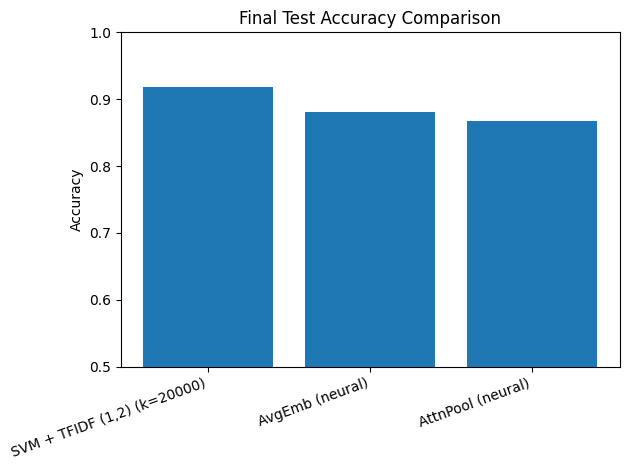

In [15]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# Make sure outputs/ exists (relative to repo root)
outputs_dir = os.path.join("..", "outputs")
os.makedirs(outputs_dir, exist_ok=True)

# Classical best (already computed above in the classical section)
classical_test_acc = test_acc  # from the classical refit-on-train+val cell
classical_name = f'{best["model"]} + {best["features"]}'

final_df = pd.DataFrame([
    {"Model": classical_name, "Split": "TEST", "Accuracy": classical_test_acc},
    {"Model": "AvgEmb (neural)", "Split": "TEST", "Accuracy": avg_test_acc},
    {"Model": "AttnPool (neural)", "Split": "TEST", "Accuracy": attn_test_acc},
]).sort_values("Accuracy", ascending=False)

display(final_df)

# Save results table
final_df.to_csv(os.path.join(outputs_dir, "final_results.csv"), index=False)

# Plot comparison bar chart
plt.figure()
plt.bar(final_df["Model"], final_df["Accuracy"])
plt.title("Final Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(outputs_dir, "final_accuracy_comparison.png"))
plt.show()


## 7) Final conclusions

The classical SVM baseline outperforms the neural baselines by ~5 percentage points. Given the task (sentiment) and the relatively small training set, this is expected: TF‑IDF with bigrams provides a very strong representation for phrase-level sentiment cues.

### Limitations
- Small dataset size for training embeddings from scratch (5k reviews)
- Simple tokenizer and fixed truncation length (may drop important context)
- Neural models do not model full token-to-token interactions (not a Transformer)
- Limited neural hyperparameter search (epochs, learning rate, dropout, embedding dim)

### Future work
- Train neural models longer with early stopping + tuning (lr, dropout, d_model)
- Use pretrained embeddings (e.g., GloVe) or a pretrained encoder
- Try architectures that capture order/interactions (CNN, BiLSTM, Transformer encoder)
- Do deeper error analysis by review length, negation, and sarcasm indicators